
[Notes **(not by me)**](https://concon.land/notes/karpathy/Lecture4)

# 1. Starter code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open('../data/names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
block_size = 3
def build_dataset(words):
    x,y = list(),list()
    for word in words:
        context=[0]*block_size
        # context is the vector representation
        for character in word+'.':
            ix = stoi[character]
            x.append(context)
            y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',character)
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    return X,Y

In [5]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train_X,train_Y = build_dataset(words[:n1])
dev_X,dev_Y = build_dataset(words[n1:n2])
test_X,test_Y = build_dataset(words[n2:])

In [6]:
n_emb = 10
n_hidden = 200
vocab_size=27
torch.manual_seed(2147483647)
generator = torch.Generator()
lookup_table = torch.randn((vocab_size,n_emb),generator=generator,requires_grad=True)
W1 = torch.randn((n_emb * block_size ,n_hidden),generator=generator,requires_grad=True)
b1 = torch.randn((n_hidden),generator=generator,requires_grad=True)
W2 = torch.randn((n_hidden,vocab_size),generator=generator,requires_grad=True)
b2 = torch.randn((vocab_size),generator=generator,requires_grad=True)
parameters=[lookup_table,W1,b1,W2,b2]
print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

Total number of parameters: 11897


In [7]:
lr_exp = torch.linspace(-2,0,1000)
lrs = 10**lr_exp

In [8]:
losses = list()
step_i = list()
lr_i = list()

In [9]:
epochs = 200000
batch_size = 32
for i in range(epochs):
    ix = torch. randint(0, train_X.shape[0], (batch_size,), generator=generator)
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y
    embedding = lookup_table[train_X[ix]]
    h = torch.tanh(embedding.view(-1,30) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()

    if i< 100000:lr=0.1 
    else:lr=0.01

    for p in parameters:
        p.data += -lr * p.grad
    
    step_i.append(i)

    if i%10000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    losses.append(loss.log10().item())

      0/ 200000: 26.9064


KeyboardInterrupt: 

In [ ]:
@torch.no_grad() #this decorator tells torch to turn off gradient tracking for this function
def split_loss(X,y):
    embedding = lookup_table[X]
    h = torch.tanh(embedding.view(-1,n_emb * block_size) @ W1 + b1)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()
print(f"train_loss={split_loss(train_X,train_Y):.4f} \ndev_loss={split_loss(dev_X,dev_Y):.4f} \ntest_loss={split_loss(test_X,test_Y):.4f}")


train_loss=2.1241 
dev_loss=2.1595 
test_loss=2.1565


In [ ]:
-torch.tensor([1/27.0]).log()

tensor([3.2958])

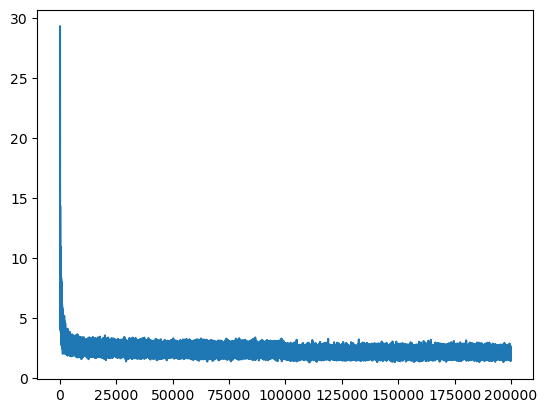

In [ ]:
plt.plot(step_i,losses)

In [ ]:
# Sampling:
generator_inference = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embedding_sample = lookup_table[torch.tensor([context])]
        h = torch.tanh(embedding_sample.view(1,-1)@W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,replacement=True,generator=generator_inference).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

carmah
amori
kihlemleigenty
hacassa
jazhitn
den
rhc
kaqui
ner
kia
chaiir
kaleigh
ham
jorn
quinn
saline
kia
biyon
elo
dearyni


# 2. Reduce the randomness in the data and get logits closer to 0.
- Initially in the training loop we're getting a very high loss and then we suddenly get to 2. something. Our goal here is to start the model right and on the right path.
    - So the final logits depend on b2 and W2. Since we need everything close to 0 b2 *0 and we multiply w2 by 0.1
    - <details><summary>making tanh better</summary>
        It also depends on the activation function of tanh.
        Now tanh is a bit messed up in the sense that if the value of tanh is +/- 1 then the gradient is 0 and we just forget all of the previous neuron (happens because chain rule and we multiply local grad with overall grad). Similarly if we have 0 then the gradient is 1 and we just pass everyhting in the gradient forward. This is happening when we simply use tanh.<br>
        <img src="../assets/graph_sat_tanh.png" alt="drawing" width="400px"> <br> In this graph we can see that the majority of weights before the tanh activation have a very high range (-20,20) and this range is then squashed completely between -1,1. 
        <br><img src="../assets/Screenshot 2024-04-30 at 22.03.44.png" width="400px"><br> In this graph you can see that a lot of the values are at the extremes (-1 and 1) and thus aren't affecting the neural network a lot, in fact they may be removing the previous gradients completely. [Video](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=779s)
        </details>
    - Now this strategy of adding normalisation constants during weight initilisation is ok for small networks but to transform them to bigger networks might be difficult. For larger networks this "vanishing" gradient will keep on increasing
        RECAP: Random output weights can cause the network to be confidently wrong, and waste early training, so we scaled them down. Random hidden layer weights can cause gradients to vanish, so we scaled them down. The goal is to find a way to scale the weights to maintain this spread so that the values don't go too out of bound.**The value of the activations must be gaussian because mean is 0 and deviation is 1 i.e. it is closer to 0 so we won't have very high numbers to give tanh thus we won't have the vanishing gradient problem.**
        [Keming et al.](https://arxiv.org/abs/1502.01852) talks about how we can do this, i.e. reduce this spread of data. The paper says that we must do $ \sqrt{\frac{2}{n_{in}}} $ where $ n_{in} $ is the number of inputs to the layer. This is called the Xavier initialisation.
- [Batch normalisation](https://arxiv.org/abs/1502.03167): If you want the weights to be gaussian just make them gaussian afterwards. 
### ["summary"](https://www.youtube.com/watch?v=P6sfmUTpUmc&t=4450s)

In [ ]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random
# https://concon.land/notes/karpathy/Lecture4

In [ ]:
words = open('../data/names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [ ]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [ ]:
block_size = 3
def build_dataset(words):
    x,y = list(),list()
    for word in words:
        context=[0]*block_size
        # context is the vector representation
        for character in word+'.':
            ix = stoi[character]
            x.append(context)
            y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',character)
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    return X,Y

In [ ]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train_X,train_Y = build_dataset(words[:n1])
dev_X,dev_Y = build_dataset(words[n1:n2])
test_X,test_Y = build_dataset(words[n2:])

In [ ]:
n_emb = 10
n_hidden = 200
vocab_size=27
torch.manual_seed(2147483647)
generator = torch.Generator()
lookup_table = torch.randn((vocab_size,n_emb),generator=generator)
# W1 = torch.randn((n_emb * block_size ,n_hidden),generator=generator) * ((5/3)/((n_emb * block_size)**0.5))
# b1 = torch.randn((n_hidden),generator=generator) * 0.1
# W2 = torch.randn((n_hidden,vocab_size),generator=generator) * 0.01
# b2 = torch.randn((vocab_size),generator=generator) * 0

W1 = torch.zeros((n_emb * block_size ,n_hidden))
b1 = torch.zeros((n_hidden))
W2 = torch.zeros((n_hidden,vocab_size))
b2 = torch.zeros((vocab_size))

bngain = torch.ones((1,n_hidden))
bnbias = torch.zeros((1,n_hidden))
bnmean_running = torch.zeros((1,n_hidden))
bnstd_running = torch.ones((1,n_hidden))


parameters=[lookup_table,W1,b1,W2,b2,bngain,bnbias]
for p in parameters:
    p.requires_grad = True
print(f'Total number of parameters: {sum(p.nelement() for p in parameters)}')

Total number of parameters: 12297


In [ ]:
step_i = list()
losses = list()

In [ ]:
epochs = 200000
batch_size = 32
for i in range(epochs):
    ix = torch. randint(0, train_X.shape[0], (batch_size,), generator=generator)
    Xb, Yb = train_X[ix], train_Y[ix] # batch X,Y
    embedding = lookup_table[train_X[ix]]
    embedding = embedding.view(embedding.shape[0],-1)
    hpreact =  embedding @ W1 + b1
    bnmean_i = hpreact.mean(0,keepdims=True)
    bnstd_i = hpreact.std(0,keepdims=True)
    hpreact = bngain * (hpreact - bnmean_i)/bnstd_i + bnbias

    with torch.no_grad():
        bnmean_running = 0.999* bnmean_running + 0.001* bnmean_i
        bnstd_running = 0.999* bnstd_running + 0.001* bnstd_i


    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, Yb)
    for p in parameters:
        p.grad = None
    loss.backward()

    if i< 100000:lr=0.1 
    else:lr=0.01
    for p in parameters:
        p.data += -lr * p.grad
    
    step_i.append(i)
    losses.append(loss.log10().item())

    if i%10000 == 0:
        print(f"{i:7d}/{epochs:7d}: {loss.item():.4f}")
    # break

      0/ 200000: nan
  10000/ 200000: nan
  20000/ 200000: nan
  30000/ 200000: nan
  40000/ 200000: nan
  50000/ 200000: nan
  60000/ 200000: nan
  70000/ 200000: nan
  80000/ 200000: nan
  90000/ 200000: nan
 100000/ 200000: nan


KeyboardInterrupt: 

In [ ]:
with torch.no_grad():
# pass the training set through
    emb = lookup_table[train_X]
    embcat = emb. view(emb.shape [0], -1)
    hpreact = embcat @ W1 + b1
    # measure the mean/std over the entire training set
    bnmean = hpreact.mean(0, keepdim=True)
    bstd = hpreact.std(0, keepdim=True)

In [ ]:
@torch.no_grad() #this decorator tells torch to turn off gradient tracking for this function
def split_loss(X,y):
    embedding = lookup_table[X]
    embedding = embedding.view(-1,n_emb * block_size)
    hpreact = embedding @ W1 + b1
    hpreact = bngain * (hpreact - bnmean)/bstd + bnbias
    h = torch.tanh(hpreact)
    logits = h @ W2 + b2
    loss = F.cross_entropy(logits, y)
    return loss.item()
print(f"train_loss={split_loss(train_X,train_Y):.4f} \ndev_loss={split_loss(dev_X,dev_Y):.4f} \ntest_loss={split_loss(test_X,test_Y):.4f}")

'''train_loss=2.0743 
dev_loss=2.1350 
test_loss=2.1360'''

'''train_loss=2.1027 
dev_loss=2.1360 
test_loss=2.1341'''

'''train_loss=2.0640 
dev_loss=2.1154 
test_loss=2.1157'''

train_loss=2.0696 
dev_loss=2.1143 
test_loss=2.1159


'train_loss=2.0640 \ndev_loss=2.1154 \ntest_loss=2.1157'

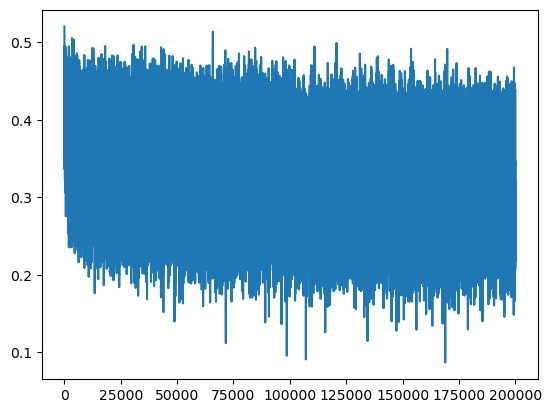

In [ ]:
plt.plot(losses)

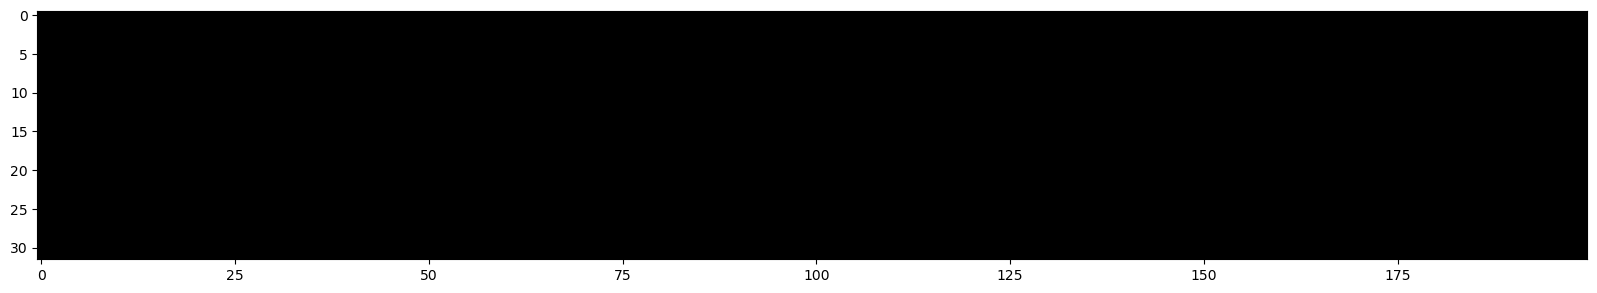

In [ ]:
plt.figure(figsize=(20,10))
plt.imshow(h.abs()>99, cmap="gray", interpolation='nearest')

(array([884., 193., 111., 101.,  70.,  85.,  74.,  54.,  50.,  49.,  40.,
         43.,  32.,  40.,  46.,  50.,  49.,  50.,  62.,  62.,  63.,  85.,
        135., 251., 445., 436., 292., 133.,  92.,  51.,  63.,  55.,  48.,
         46.,  42.,  48.,  48.,  51.,  46.,  49.,  65.,  57.,  68.,  56.,
         68.,  88., 115., 140., 211., 908.]),
 array([-1.  , -0.96, -0.92, -0.88, -0.84, -0.8 , -0.76, -0.72, -0.68,
        -0.64, -0.6 , -0.56, -0.52, -0.48, -0.44, -0.4 , -0.36, -0.32,
        -0.28, -0.24, -0.2 , -0.16, -0.12, -0.08, -0.04,  0.  ,  0.04,
         0.08,  0.12,  0.16,  0.2 ,  0.24,  0.28,  0.32,  0.36,  0.4 ,
         0.44,  0.48,  0.52,  0.56,  0.6 ,  0.64,  0.68,  0.72,  0.76,
         0.8 ,  0.84,  0.88,  0.92,  0.96,  1.  ]),
 <BarContainer object of 50 artists>)

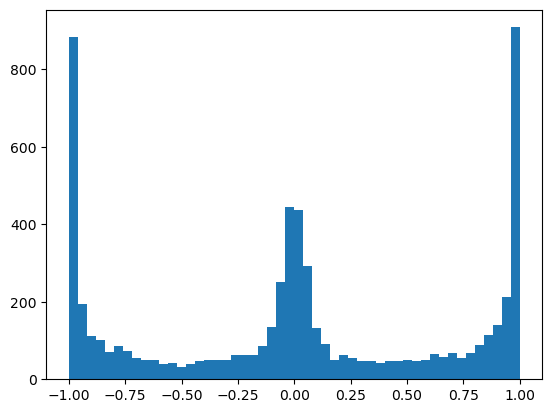

In [ ]:
plt.hist(h.view(-1).tolist(), 50)

# 3. Pytorchifying the code

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import random

In [2]:
words = open('../data/names.txt','r').read().splitlines()
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

In [3]:
chars = sorted(set(''.join(words)))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}

In [4]:
block_size = 3
def build_dataset(words):
    x,y = list(),list()
    for word in words:
        context=[0]*block_size
        # context is the vector representation
        for character in word+'.':
            ix = stoi[character]
            x.append(context)
            y.append(ix)
            # print(''.join(itos[i] for i in context),'--->',character)
            context = context[1:] + [ix]
    X = torch.tensor(x)
    Y = torch.tensor(y)
    return X,Y

In [5]:
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

train_X,train_Y = build_dataset(words[:n1])
dev_X,dev_Y = build_dataset(words[n1:n2])
test_X,test_Y = build_dataset(words[n2:])

In [6]:
class Linear:
    def __init__(self,in_features,out_features,bias=True):
        self.weights = torch.randn((in_features,out_features),generator=generator)/(in_features**0.5)
        if bias:
            self.bias = torch.zeros(out_features)
        else:
            self.bias = None
    def __call__(self,x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    def parameters(self):
        return [self.weights] + ([] if self.bias is None else [self.bias])

class BatchNorm1D:
    def __init__(self,dim,eps=1e-5,momentum=0.5):
        self.eps = eps
        self.momentum = momentum
        self.training = True
        # parameters trained with backprop
        self.gamma = torch.ones (dim)
        self. beta = torch.zeros (dim)
        # buffers (trained with a running 'momentum update')
        self. running_mean = torch.zeros (dim)
        self. running_var = torch.ones (dim)
    def __call__(self, x):
        # calculate the forward pass
        if self.training:
            xmean = x.mean(0, keepdim=True) # batch mean
            xvar = x.var(0, keepdim=True) # batch variance
        else:
            xmean = self. running_mean
            xvar = self. running_var
        xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
        self.out = self.gamma * xhat + self. beta
        # update the buffers
        if self.training:
            with torch.no_grad():
                self. running_mean = (1 - self.momentum) * self. running_mean + self.momentum * xmean
                self. running_var = (1 - self.momentum) * self. running_var + self.momentum * xvar
        return self.out

    def parameters(self):
        return [self.gamma, self.beta]
class Tanh:
    def __call__(self,x):
        self.out = torch.tanh(x)
        return self.out
    def parameters(self):
        return []

In [7]:
n_emb = 10
n_hidden = 100
block_size = 3
vocab_size = 27
generator = torch.Generator().manual_seed(2147483647)

lookup_table = torch.randn((vocab_size,n_emb),generator=generator)
layers = [
    Linear(n_emb*block_size,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden,n_hidden,bias=False),BatchNorm1D(n_hidden) ,Tanh(),
    Linear(n_hidden,vocab_size,bias=False), BatchNorm1D(vocab_size)
]
with torch.no_grad():
    # layers[-1].weights *= 0.1
    layers[-1].gamma *= 0.1
    for layer in layers [:-1]: 
        if isinstance(layer, Linear):
            layer.weights *= 1.0
parameters = [lookup_table] + [p for layer in layers for p in layer.parameters ()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

47024


In [8]:
epochs = 200000
batch_size = 32
losses = list()
for i in range(epochs):
    ix = torch.randint(0,train_X.shape[0],(batch_size,),generator=generator)
    Xb,Yb = train_X[ix],train_Y[ix]
    embedding = lookup_table[Xb]
    x = embedding.view(embedding.shape[0],-1)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x,Yb)
    losses.append(loss)
    for layer in layers:
        layer.out.retain_grad()
    for p in parameters:
        p.grad = None
    loss.backward()
    lr = 0.1 if i<100000 else 0.01
    for p in parameters:
        p.data += -lr*p.grad
    if i%10000 == 0:
        print(f"{i:7d}/{epochs:4d}: {loss.item():.4f}")

      0/200000: 3.2870
  10000/200000: 2.3273
  20000/200000: 2.1019
  30000/200000: 1.9020
  40000/200000: 2.1643
  50000/200000: 2.1520
  60000/200000: 1.7767
  70000/200000: 2.1514
  80000/200000: 2.3802
  90000/200000: 1.9338
 100000/200000: 2.3943
 110000/200000: 2.1620
 120000/200000: 2.1407
 130000/200000: 2.0210
 140000/200000: 1.7178
 150000/200000: 1.9392
 160000/200000: 1.9820
 170000/200000: 2.0205
 180000/200000: 2.2461
 190000/200000: 1.9765


In [9]:
with torch.no_grad():
# pass the training set through
    emb = lookup_table[train_X]
    x = emb. view(emb.shape [0], -1)
    for layer in layers:
        x = layer(x)

In [10]:
@torch.no_grad() #this decorator tells torch to turn off gradient tracking for this function
def split_loss(X,y):
    embedding = lookup_table[X]
    x = embedding.view(-1,n_emb * block_size)
    for layer in layers:
        x = layer(x)
    loss = F.cross_entropy(x, y)
    return loss.item()
print(f"train_loss={split_loss(train_X,train_Y):.4f} \ndev_loss={split_loss(dev_X,dev_Y):.4f} \ntest_loss={split_loss(test_X,test_Y):.4f}")

'''train_loss=2.0743 
dev_loss=2.1350 
test_loss=2.1360'''

'''train_loss=2.1027 
dev_loss=2.1360 
test_loss=2.1341'''

'''train_loss=2.0640 
dev_loss=2.1154 
test_loss=2.1157'''

train_loss=2.0066 
dev_loss=2.0792 
test_loss=2.0811


'train_loss=2.0640 \ndev_loss=2.1154 \ntest_loss=2.1157'

In [13]:
# Sampling:
for layer in layers:
    layer.training=False
generator_inference = torch.Generator().manual_seed(2147483647 + 10)
for _ in range(20):
    out = []
    context = [0] * block_size
    while True:
        embedding_sample = lookup_table[torch.tensor([context])]
        x = embedding_sample.view(embedding_sample.shape[0],-1)
        for layer in layers:
            x = layer(x)
        logits = x
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1,generator=generator_inference).item()
        context = context[1:] + [ix]
        if ix == 0:
            break
        out.append(ix)
    print(''.join(itos[i] for i in out))

carmahzato
harli
jari
reigh
skanden
jazhith
deliah
jareen
nellara
chaiivia
leigh
ham
joce
quinthoroine
liven
corathoniearyxia
kaellissa
med
edi
abette
